In [1]:
import project.train_logger as train_logger
import matplotlib.pyplot as plt

In [29]:
logger = train_logger.TrainingLogger("../odnlggds.db")

In [30]:
exp_id_real = logger.register_experiment(name="Real")
exp_id_contolle = logger.register_experiment(name="Controlle")
exp_id_our = logger.register_experiment(name="Our")

(1,)
(2,)
(3,)


In [56]:
for id in logger.get_experiment_ids():
    print(id, logger.get_experiment_name(id))

1 Real
2 Controlle
3 Our


In [69]:
for exp in logger.get_experiment_ids():
    results = logger.get_results(exp)
    print(f"Experiment {exp}: {logger.get_experiment_name(exp)}")
    print(f"run_id | epoch| train_loss| train_acc| test_loss| test_acc")
    for run_id, epoch, train_loss, train_acc, test_loss, test_acc in results:
        print(f"{run_id:7d}| {epoch:5d}| {train_loss:10.2f}| {train_acc:9.2f}| {test_loss:9.2f}| {test_acc:8.2f}")

Experiment 1: Real
run_id | epoch| train_loss| train_acc| test_loss| test_acc
      1|     0|       1.74|      0.36|      1.31|     0.51
      1|     1|       1.42|      0.49|      1.16|     0.58
      1|     2|       1.28|      0.55|      1.02|     0.65
      1|     3|       1.16|      0.59|      0.94|     0.67
      1|     4|       1.07|      0.62|      0.87|     0.69
      1|     5|       1.01|      0.65|      0.86|     0.70
      1|     6|       0.95|      0.67|      0.81|     0.72
      1|     7|       0.90|      0.69|      0.80|     0.73
      1|     8|       0.86|      0.70|      0.76|     0.74
      1|     9|       0.82|      0.71|      0.76|     0.74
      1|    10|       0.78|      0.73|      0.72|     0.75
      1|    11|       0.75|      0.74|      0.71|     0.75
      2|     0|       1.75|      0.35|      1.33|     0.52
      2|     1|       1.43|      0.49|      1.14|     0.59
      2|     2|       1.28|      0.55|      1.02|     0.63
      2|     3|       1.17|      0.59

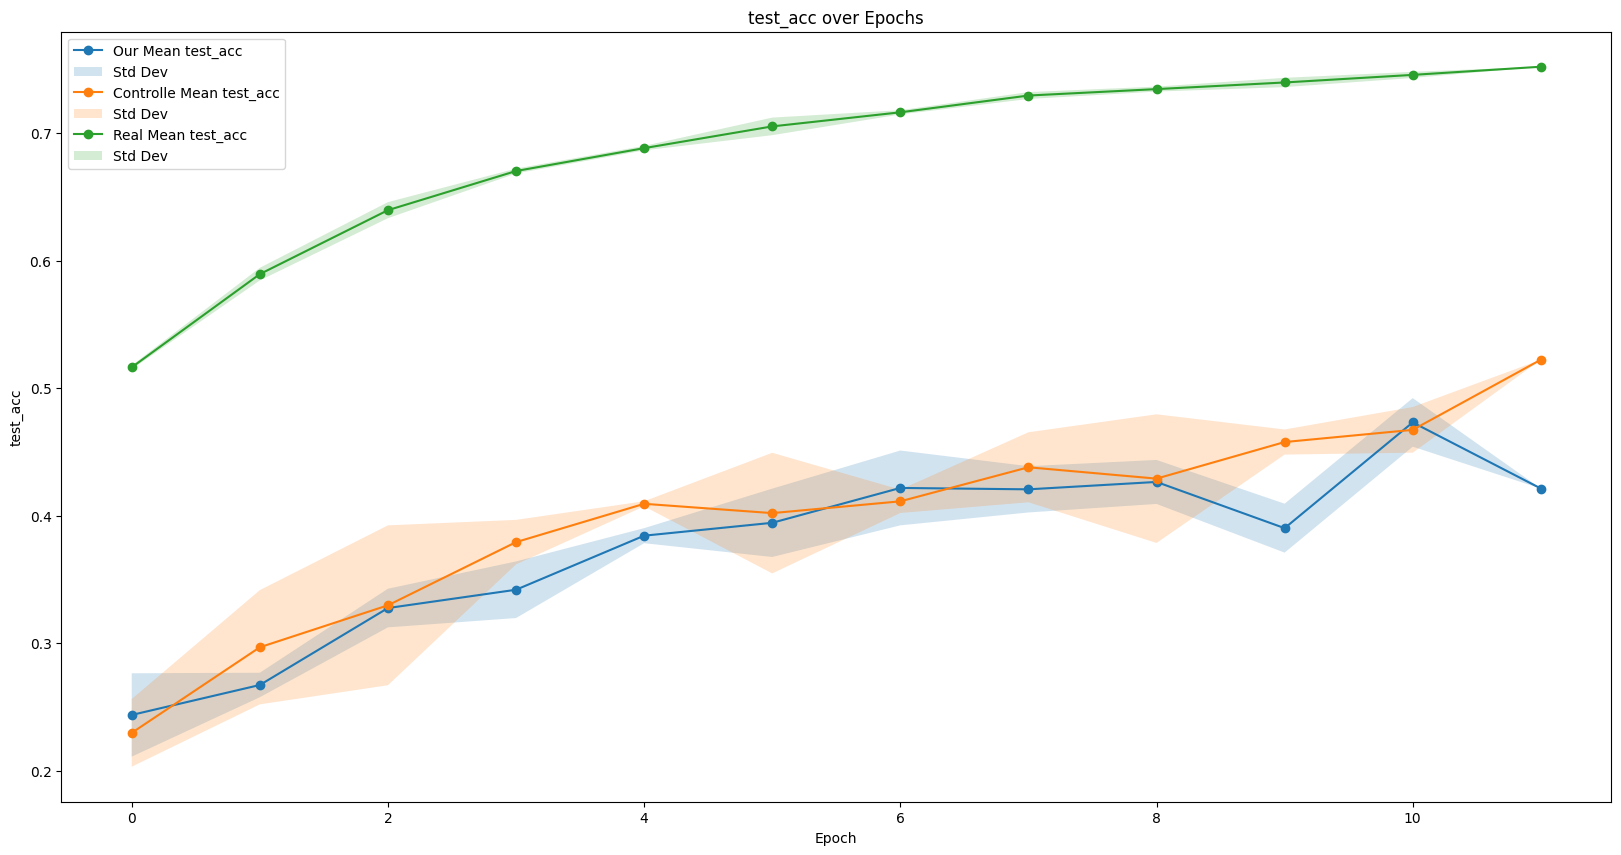

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
train_logger.plot_metric(logger, exp_id_our, exp_id_contolle, exp_id_real, metric='test_acc', ax=ax)